In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180. # radians / degree
yr = 365.25 # days / year

In [4]:
# load all the data
data_cfa = ascii.read("data/cfa.dat")
# cfa errors are provided in table 

data_dupont = ascii.read("data/dupont.dat", fill_values=[("X", 0)])
err_dupont = {"Aa":1.46, "Ab":2.34, "B":3.95} # km/s

data_feros = ascii.read("data/feros.dat")
err_feros = {"Aa":2.61, "Ab":3.59, "B":2.60} # km/s

data_keck = ascii.read("data/keck.dat", format="tab", fill_values=[("X", 0)])
err_keck = {"Aa":0.63, "Ab":0.85, "B":0.59} # km/s

data = [data_cfa, data_dupont, data_feros, data_keck]

# date is HJD + 2400000

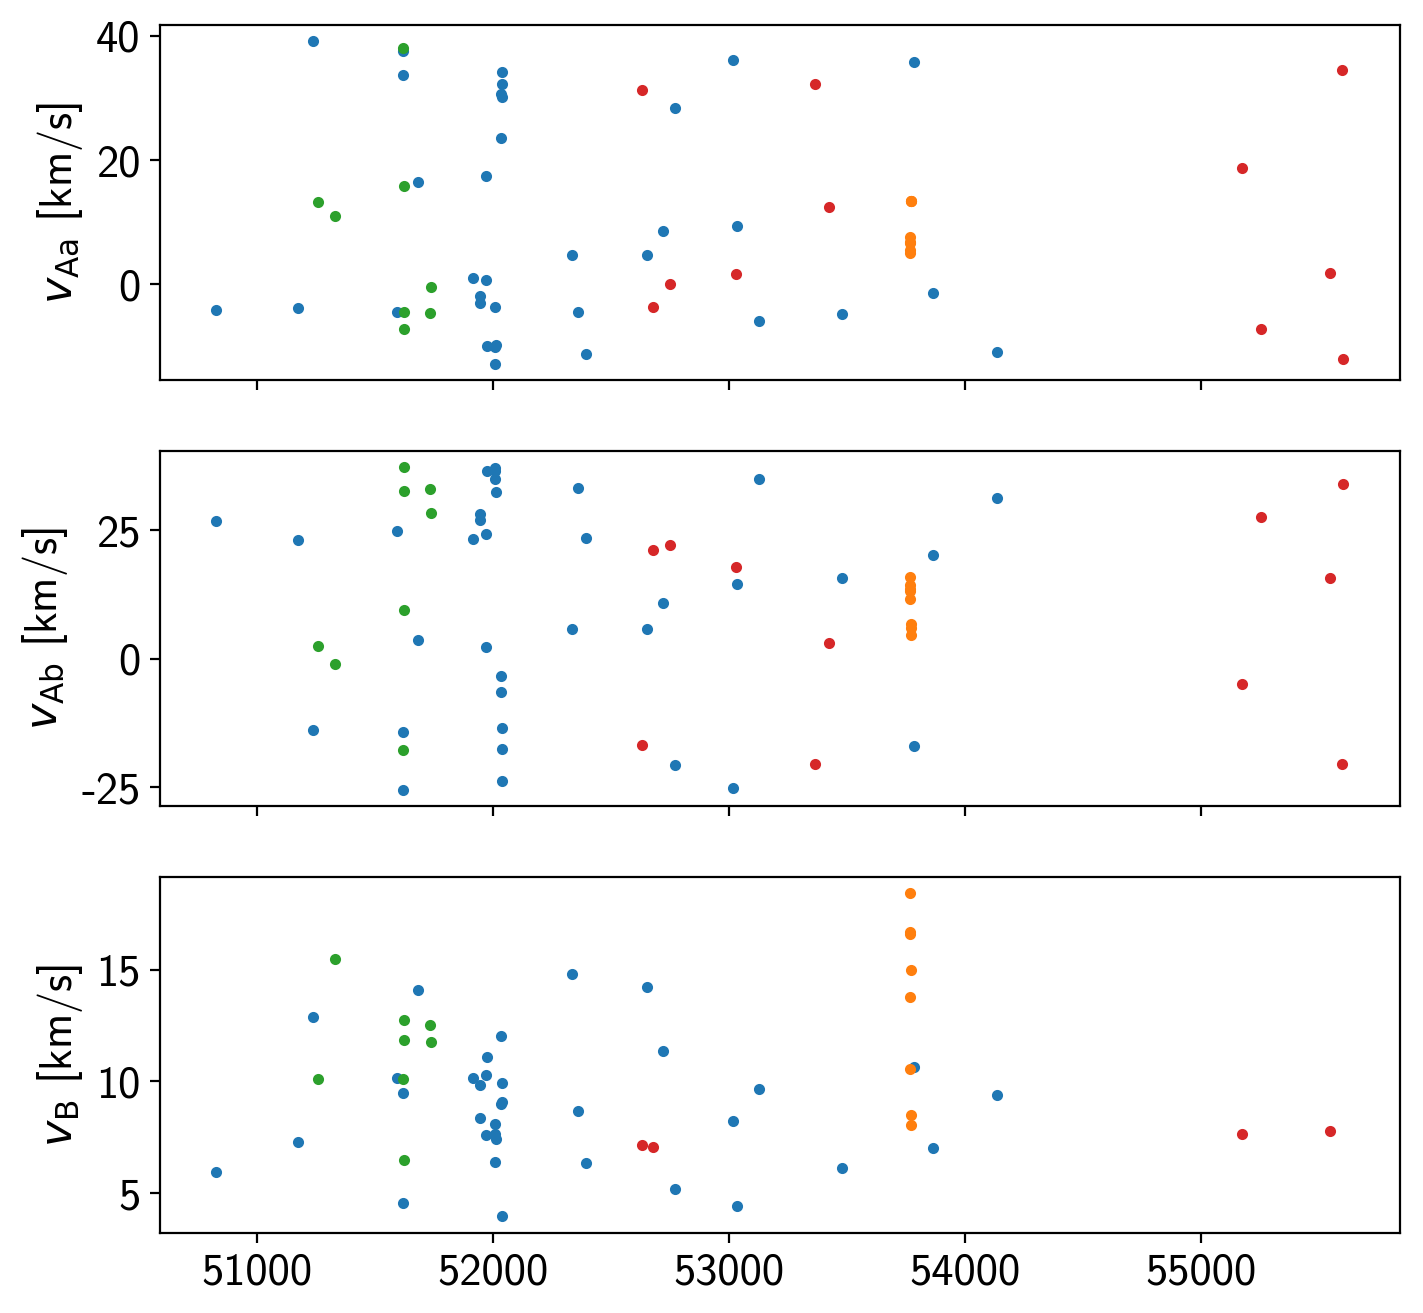

In [46]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(8,8))

pkw = {"marker":".", "ls":""}

for d in data:
    ax[0].plot(d["HJD"], d["RV_Aa"], **pkw)
    ax[0].set_ylabel(r"$v_\mathrm{Aa}$ [km/s]")
    
    ax[1].plot(d["HJD"], d["RV_Ab"], **pkw)
    ax[1].set_ylabel(r"$v_\mathrm{Ab}$ [km/s]")
    
    ax[2].plot(d["HJD"], d["RV_B"], **pkw)
    ax[2].set_ylabel(r"$v_\mathrm{B}$ [km/s]")
    
#     ax[1].plot(d[])

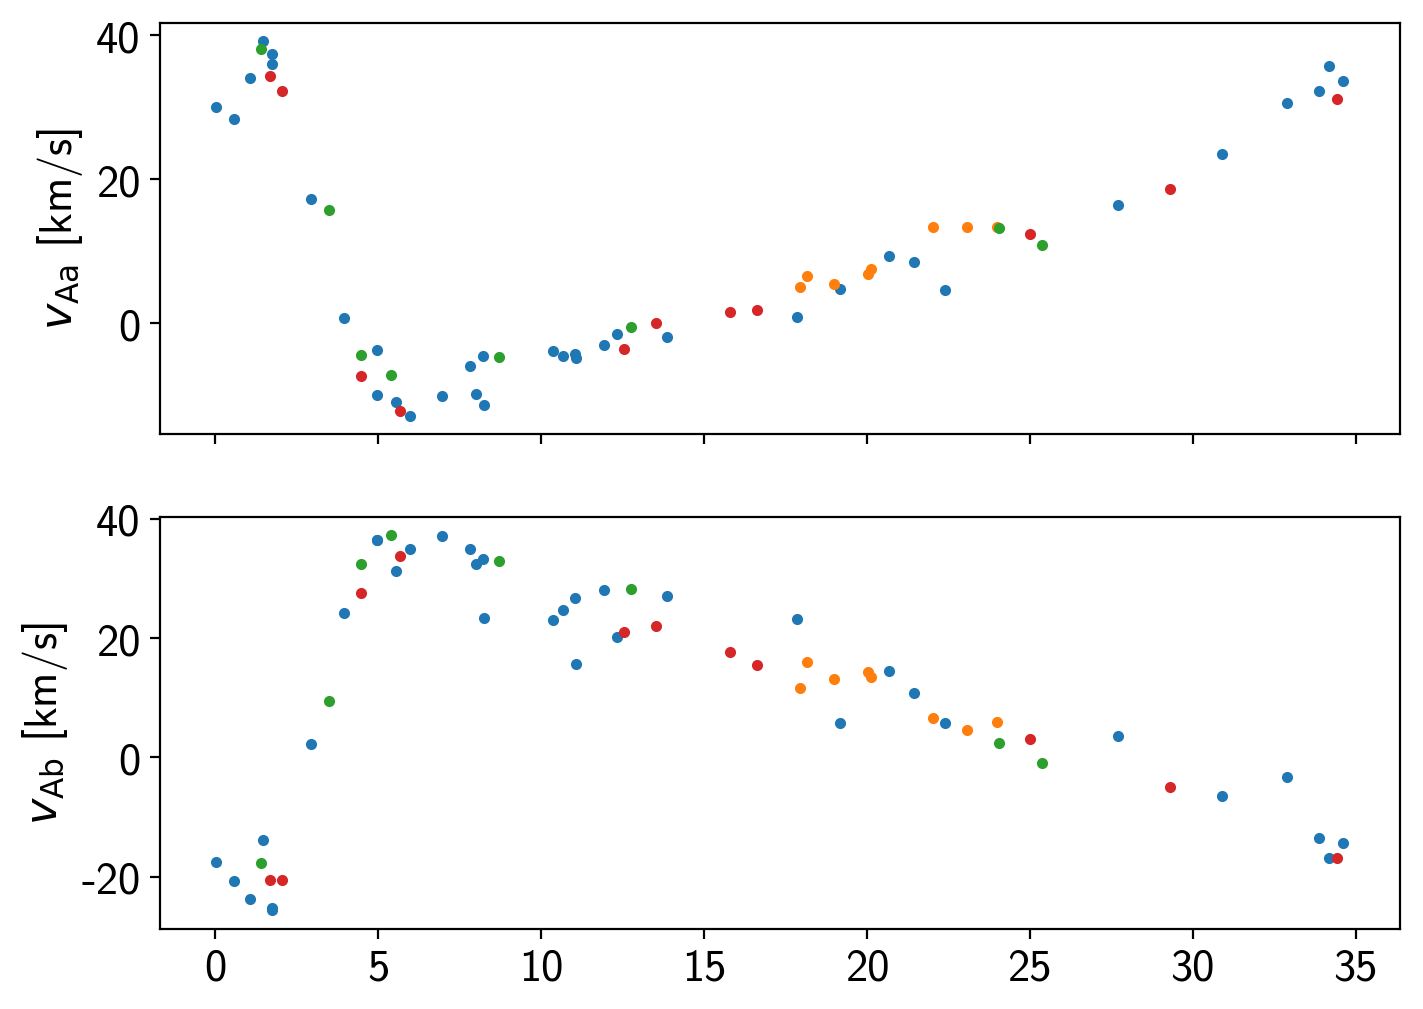

In [8]:
# try phase folding the data for Aa and Ab
P_A = 34.87846 # pm 0.00090 days

pkw = {"marker":".", "ls":""}

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8,6))

for d in data:
    ax[0].plot(d["HJD"] % P_A, d["RV_Aa"], **pkw)
    ax[0].set_ylabel(r"$v_\mathrm{Aa}$ [km/s]")
    
    ax[1].plot(d["HJD"] % P_A, d["RV_Ab"], **pkw)
    ax[1].set_ylabel(r"$v_\mathrm{Ab}$ [km/s]")
    

In [6]:
# load the exoplanet part 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

In [ ]:
with pm.Model() as model:

    # parameters
    # P, gamma, Ka, Kb, e, omegaA, T0
    # Delta CfA - Keck
    # Delta CfA - Feros
    # Delta CfA - du Pont
    # jitter for each instrument?

    # Parameters
    logK = pm.Uniform("logK", lower=0, upper=np.log(200),
                      testval=np.log(0.5*(np.max(rv) - np.min(rv))))
    logP = pm.Uniform("logP", lower=0, upper=np.log(10),
                      testval=np.log(lit_period))
    phi = pm.Uniform("phi", lower=0, upper=2*np.pi, testval=0.1)
    e = pm.Uniform("e", lower=0, upper=1, testval=0.1)
    omega = Angle("w") # omega_a
#     logjitter = pm.Uniform("logjitter", lower=-10, upper=5,
                           testval=np.log(np.mean(rv_err)))
    
    gamma = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
    
    orbit = xo.orbits.KeplerianOrbit( ecc=e, )
    
    orbit.get_radial_velocity(jds, K, units=)
    orbit.get_radial_velocity(jds, )
    
    # Deterministic transformations
    n = 2*np.pi*tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    s2 = tt.exp(2*logjitter)
    t0 = (phi + w) / n

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)

    # This is the line that uses the custom Kepler solver
    f = get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", bkg + K * (cosw*(tt.cos(f) + e) - sinw*tt.sin(f)))

    # Condition on the observations
    err = tt.sqrt(rv_err**2 + tt.exp(2*logjitter))
    pm.Normal("obs", mu=rvmodel, sd=err, observed=rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2*np.pi * phase - (phi + w)
    f_pred = get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw*(tt.cos(f_pred) + e) - sinw*tt.sin(f_pred)))